# Analysis and Figure Generation

This notebook reproduces all analyses, figures, and regression results reported in the [paper](https://arxiv.org/abs/2404.05861) using the processed citation preference data.

It relies on the outputs generated by the preceding notebooks, in particular:

- Citation preference and bootstrap estimates produced by **2_GlobalCitationNetwork_citationPreference**
- Processed country–country citation and metadata files archived in the shared data folder

For convenience and reproducibility, we have also archived the outputs of the first two notebooks. As a result, this notebook can be run **as a standalone workflow** using the archived processed data, without rerunning the data preparation or citation preference estimation steps.

Running this notebook end-to-end will reproduce all main figures and regression tables in the manuscript and supplementary information.

In [1]:
import os
import json
import gzip
import itertools
from itertools import chain
import pandas as pd
import numpy as np
import networkx as nx

import scipy.sparse as spsparse
import scipy.stats as spstats

from statsmodels.stats.multitest import multipletests as holm
import statsmodels.api as sm

import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import matplotlib.transforms as mtransforms
import seaborn as sns

from vizutils import pvalue2stars, table_row, make_multinomial_latex_table, logistic_coefficient_plot

import pyscisci.all as pyscisci

# set this path to where the OpenAlex database is stored
path2openalex = '/Users/hgt6rn/Documents/DataSets/OpenAlex'

# set this path to where the processed data is stored:
path2countrydata = "data"

# OR if you used our previous notebooks to generate, then set this to
#path2countrydata = "/Users/hgt6rn/Documents/DataSets/OpenAlex/precomputed_metrics"

 # Analysis of the International Recognition Network

In [2]:
# lets focus on the citation without the same organization and self citations

country_auc_df = pd.read_csv(os.path.join(path2countrydata, 'oa_countrycites_nosameorg_auc.csv.gz'))

country_auc_df = country_auc_df[country_auc_df['N']>=50]

country_auc_df['Zscore'] = (country_auc_df['AUC'] - 0.5)/np.sqrt(country_auc_df['Cov'])
country_auc_df['pvalue'] = spstats.norm.sf(np.abs(country_auc_df['Zscore'].values))

def reject_holm(pvalues):
    reject, pvalues, _, _ = holm(pvalues, alpha=0.01, method='hs', is_sorted=False, returnsorted=False)
    return reject
country_auc_df['Significant'] = country_auc_df.groupby('CitedYear')['pvalue'].transform(reject_holm)

net_auc = country_auc_df[country_auc_df['CitingCountry'] != country_auc_df['CitedCountry']].sort_values(by=['CitedYear', 'CitedCountry']).reset_index(drop=True)
net_auc = net_auc[net_auc['Significant']]
self_auc = country_auc_df[country_auc_df['CitingCountry'] == country_auc_df['CitedCountry']].sort_values(by=['CitedYear', 'CitedCountry']).reset_index(drop=True)
self_auc = self_auc[self_auc['Significant']]

syear, eyear = 1990, 2017
net_auc = net_auc[net_auc['CitedYear'] >= syear]
net_auc = net_auc[net_auc['CitedYear'] <= eyear]

comm2country = {0:['AE', 'BD', 'CN', 'CY', 'DZ', 'EG', 'ID', 'IN', 'IQ', 'IR', 'JO', 'KH', 'KR', 'KW', 'MA', 'MY', 'OM', 'PK', 'QA', 'SA', 'SG', 'TH', 'TN', 'TR', 'TW', 'VN'],
1:['AR', 'BN', 'BO', 'BR', 'BW', 'BY', 'CL', 'CM', 'CO', 'CR', 'GE', 'HK', 'HR', 'LU', 'MZ', 'NC', 'PA', 'PE', 'RU', 'SJ', 'ST', 'UY', 'VE'],
2:['AT', 'BE', 'CA', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR', 'HU', 'IE', 'IL', 'IS', 'IT', 'JP', 'MX', 'NL', 'NO', 'NP', 'NZ', 'PH', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK'],
3:['AU', 'CH', 'GB', 'US'],
4:['BH', 'ET', 'GH', 'KE', 'MW', 'NG', 'TZ', 'UG', 'ZA', 'ZM', 'ZW']}

country2comm = {c:ci for ci,clist in comm2country.items() for c in clist}
poscountrylist = sorted(list(country2comm.keys()))

connected_countries = np.sort(np.unique(net_auc[net_auc['Zscore'] > 0][['CitingCountry', 'CitedCountry']].values.flatten()))

In [3]:
syear, eyear = 1990, 2017
net_auc = net_auc[net_auc['CitedYear'] >= syear]
net_auc = net_auc[net_auc['CitedYear'] <= eyear]
cumulative_net = net_auc.sort_values('CitedYear').drop_duplicates(subset=['CitingCountry', 'CitedCountry'], keep='last')

cumulative_net['SourceCommunity'] = cumulative_net['CitingCountry'].map(country2comm)
cumulative_net['TargetCommunity'] = cumulative_net['CitedCountry'].map(country2comm)
cumulative_net['InterCommunity'] = cumulative_net['SourceCommunity'] != cumulative_net['TargetCommunity']

print(cumulative_net.shape, "edges")
cum_connected_countries = np.sort(np.unique(cumulative_net[['CitingCountry', 'CitedCountry']].values.flatten()))
print(cum_connected_countries.shape, "countries")
pcumnet = cumulative_net[cumulative_net['Zscore'] > 0]
print(pcumnet.shape, "positive edges")
print(pcumnet['CitedCountry'].value_counts())
ncumnet = cumulative_net[cumulative_net['Zscore'] < 0]
print(ncumnet.shape, "negative edges")
print(ncumnet['CitedCountry'].value_counts())

(2007, 12) edges
(147,) countries
(536, 12) positive edges
CitedCountry
CH    36
GB    31
NL    22
DE    22
BE    20
      ..
RU     1
CR     1
HR     1
PE     1
MA     1
Name: count, Length: 81, dtype: int64
(1471, 12) negative edges
CitedCountry
CN    86
JP    63
IR    48
BR    45
TR    45
      ..
CG     1
TJ     1
PH     1
HK     1
GD     1
Name: count, Length: 126, dtype: int64


## relationship between Degree and Productivity

In [4]:
countryprod = pd.read_csv(os.path.join(path2countrydata, 'oa_country_productivity.csv'))
syear = 1990
eyear = 2017

countryprod = countryprod[countryprod['Year'] >= syear]
countryprod = countryprod[countryprod['Year'] <= eyear].reset_index(drop=True)
print(countryprod.shape)

(5869, 5)


In [5]:
deg_table = cumulative_net[cumulative_net['Zscore'] > 0].groupby('CitedCountry', as_index=False)['CitingCountry'].nunique()
deg_table = deg_table.rename(columns={'CitedCountry':'Country', 'CitingCountry':'Pos. In Deg'})

deg_table2 = cumulative_net[cumulative_net['Zscore'] > 0].groupby('CitingCountry', as_index=False)['CitedCountry'].nunique()
deg_table2 = deg_table2.rename(columns={'CitingCountry':'Country', 'CitedCountry':'Pos. Out Deg'})
deg_table = deg_table.merge(deg_table2, how='outer')

deg_table3 = cumulative_net[cumulative_net['Zscore'] < 0].groupby('CitedCountry', as_index=False)['CitingCountry'].nunique()
deg_table3 = deg_table3.rename(columns={'CitedCountry':'Country', 'CitingCountry':'Neg. In Deg'})
deg_table = deg_table.merge(deg_table3, how='outer')

deg_table4 = cumulative_net[cumulative_net['Zscore'] < 0].groupby('CitingCountry', as_index=False)['CitedCountry'].nunique()
deg_table4 = deg_table4.rename(columns={'CitingCountry':'Country', 'CitedCountry':'Neg. Out Deg'})
deg_table = deg_table.merge(deg_table4, how='outer')

deg_table = deg_table.merge(countryprod[countryprod['Year']==2017][['Country', 'NumPub']], how='left')
deg_table = deg_table.fillna(0)

deg_table

,Country,Pos. In Deg,Pos. Out Deg,Neg. In Deg,Neg. Out Deg,NumPub
0,AE,4.0,2.0,9.0,3.0,4997
1,AF,0.0,0.0,0.0,1.0,122
2,AG,0.0,0.0,0.0,1.0,204
3,AL,0.0,0.0,2.0,1.0,572
4,AM,0.0,0.0,2.0,2.0,1055
...,...,...,...,...,...,...
142,XK,0.0,0.0,2.0,2.0,631
143,YE,0.0,0.0,1.0,0.0,403
144,ZA,11.0,14.0,11.0,16.0,23661
145,ZM,1.0,1.0,2.0,4.0,702


A 7.301527208769858e-08
B 5.5096794626183193e-17
C 6.037579349008931e-14
D 1.5724814676183918e-44


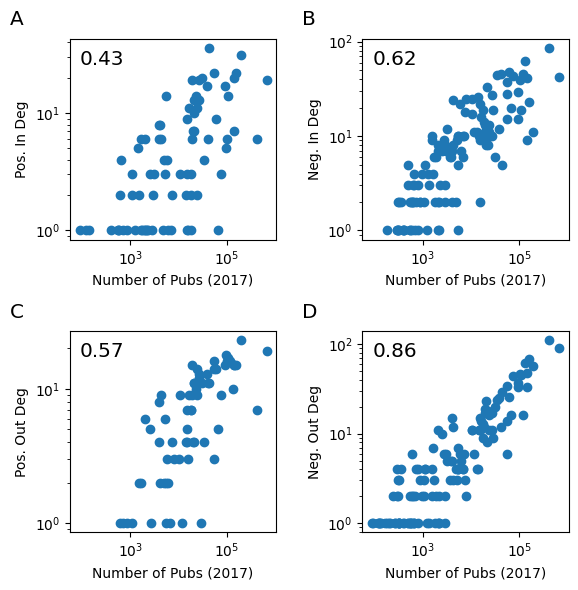

In [6]:
fig, ax = plt.subplots(2,2,figsize=(6,6))

fig_list = [('A', 'Pos. In Deg'), ('B', 'Neg. In Deg'), ('C', 'Pos. Out Deg'), ('D', 'Neg. Out Deg')]
for i, (lbl, yvar) in enumerate(fig_list):
    lax = ax[i//2,i%2]
    lax.scatter(deg_table['NumPub'], deg_table[yvar])
    lax.set_xscale('log')
    lax.set_yscale('log')
    lax.set_ylabel(yvar, fontsize=10)
    lax.set_xlabel('Number of Pubs (2017)', fontsize=10)

    corr = spstats.pearsonr(deg_table['NumPub'], deg_table[yvar])
    #corr = spstats.spearmanr(deg_table['NumPub'], deg_table[yvar])
    corr_str = str(np.round(corr.statistic,2))
    print(lbl, corr.pvalue)
    trans = mtransforms.ScaledTranslation(0.1, -0.3, fig.dpi_scale_trans)
    lax.text(0.0, 1.0, corr_str, transform=lax.transAxes + trans,
                   fontsize='x-large', va='bottom')

    trans = mtransforms.ScaledTranslation(-0.6, 7/72, fig.dpi_scale_trans)
    lax.text(0.0, 1.0, lbl, transform=lax.transAxes + trans,
                   fontsize='x-large', va='bottom')

plt.tight_layout()

plt.show()

D 1.019899490895749e-26
E 5.216950854231589e-23
F 3.0042940684550073e-07
A 0.091939989100021
B 0.0342705024511236
C 0.376347547607824


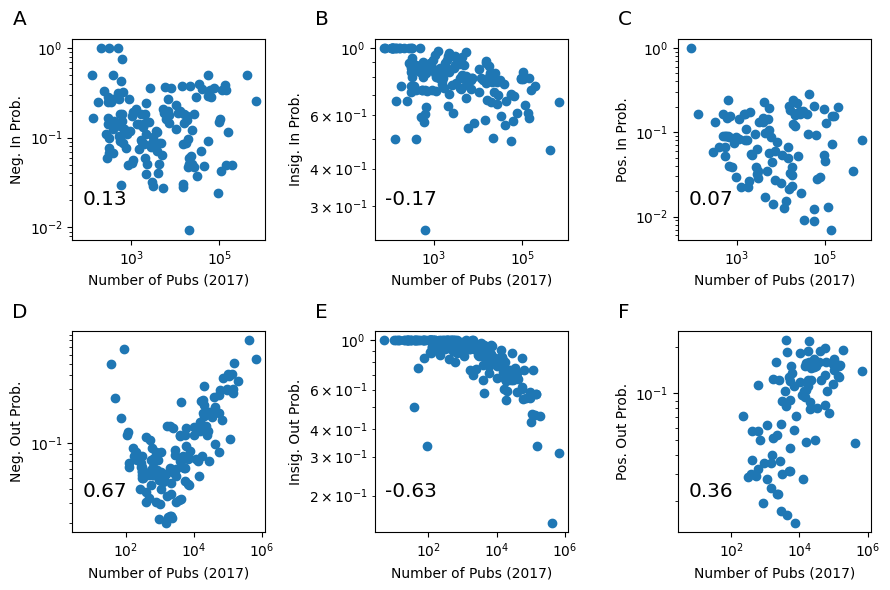

In [7]:
country_auc_df = pd.read_csv(os.path.join(path2countrydata, 'oa_countrycites_nosameorg_auc.csv.gz'))

country_auc_df['Zscore'] = (country_auc_df['AUC'] - 0.5)/np.sqrt(country_auc_df['Cov'])

n2017 = country_auc_df[country_auc_df['CitedYear'] == 2017]
n2017 = n2017[n2017['N'] >= 50].reset_index(drop=True)
n2017['Sign'] = 0
n2017.loc[n2017['Zscore']<-3, 'Sign'] = -1
n2017.loc[n2017['Zscore']>3, 'Sign'] = 1


prob_edge = []
for c in n2017['CitingCountry'].unique():
    csub = n2017[n2017['CitingCountry']==c]['Sign'].value_counts().to_dict()
    prob_edge.append([c] + [csub.get(v, 0) for v in [-1, 0, 1]])

prob_edge = pd.DataFrame(prob_edge, columns= ['Country', 'Neg. Out Prob.', 'Insig. Out Prob.', 'Pos. Out Prob.']) 
prob_edge['Total'] = prob_edge[['Neg. Out Prob.', 'Insig. Out Prob.', 'Pos. Out Prob.']].sum(axis=1)
for c in ['Neg. Out Prob.', 'Insig. Out Prob.', 'Pos. Out Prob.']:
    prob_edge[c] = prob_edge[c]/prob_edge['Total']

prob_edge = prob_edge.merge(countryprod[countryprod['Year']==2017][['Country', 'NumPub']], how='left')
prob_edge = prob_edge.fillna(0)

fig, ax = plt.subplots(2,3,figsize=(9,6))

fig_list = [('D', 'Neg. Out Prob.'), ('E', 'Insig. Out Prob.'), ('F', 'Pos. Out Prob.')]
for i, (lbl, yvar) in enumerate(fig_list):
    lax = ax[1,i]
    lax.scatter(prob_edge['NumPub'], prob_edge[yvar])
    lax.set_xscale('log')
    lax.set_yscale('log')
    lax.set_ylabel(yvar, fontsize=10)
    lax.set_xlabel('Number of Pubs (2017)', fontsize=10)

    corr = spstats.pearsonr(prob_edge['NumPub'], prob_edge[yvar])
    print(lbl, corr.pvalue)
    #corr = spstats.spearmanr(deg_table['NumPub'], deg_table[yvar])
    corr_str = str(np.round(corr.statistic,2))
    
    trans = mtransforms.ScaledTranslation(0.1, -1.7, fig.dpi_scale_trans)
    lax.text(0.0, 1.0, corr_str, transform=lax.transAxes + trans,
                   fontsize='x-large', va='bottom')

    trans = mtransforms.ScaledTranslation(-0.6, 7/72, fig.dpi_scale_trans)
    lax.text(0.0, 1.0, lbl, transform=lax.transAxes + trans,
                   fontsize='x-large', va='bottom')


prob_edge = []
for c in n2017['CitedCountry'].unique():
    csub = n2017[n2017['CitedCountry']==c]['Sign'].value_counts().to_dict()
    prob_edge.append([c] + [csub.get(v, 0) for v in [-1, 0, 1]])

prob_edge = pd.DataFrame(prob_edge, columns= ['Country', 'Neg. In Prob.', 'Insig. In Prob.', 'Pos. In Prob.']) 
prob_edge['Total'] = prob_edge[['Neg. In Prob.', 'Insig. In Prob.', 'Pos. In Prob.']].sum(axis=1)
for c in ['Neg. In Prob.', 'Insig. In Prob.', 'Pos. In Prob.']:
    prob_edge[c] = prob_edge[c]/prob_edge['Total']

prob_edge = prob_edge.merge(countryprod[countryprod['Year']==2017][['Country', 'NumPub']], how='left')
prob_edge = prob_edge.fillna(0)



fig_list = [('A', 'Neg. In Prob.'), ('B', 'Insig. In Prob.'), ('C', 'Pos. In Prob.')]
for i, (lbl, yvar) in enumerate(fig_list):
    lax = ax[0, i]
    lax.scatter(prob_edge['NumPub'], prob_edge[yvar])
    lax.set_xscale('log')
    lax.set_yscale('log')
    lax.set_ylabel(yvar, fontsize=10)
    lax.set_xlabel('Number of Pubs (2017)', fontsize=10)

    corr = spstats.pearsonr(prob_edge['NumPub'], prob_edge[yvar])
    print(lbl, corr.pvalue)
    #corr = spstats.spearmanr(deg_table['NumPub'], deg_table[yvar])
    corr_str = str(np.round(corr.statistic,2))
    
    trans = mtransforms.ScaledTranslation(0.1, -1.7, fig.dpi_scale_trans)
    lax.text(0.0, 1.0, corr_str, transform=lax.transAxes + trans,
                   fontsize='x-large', va='bottom')

    trans = mtransforms.ScaledTranslation(-0.6, 7/72, fig.dpi_scale_trans)
    lax.text(0.0, 1.0, lbl, transform=lax.transAxes + trans,
                   fontsize='x-large', va='bottom')





plt.tight_layout()

plt.show()


In [8]:
pin = []
nin = []
pout = []
nout = []

for y in np.arange(syear, eyear + 1):
    ysub = net_auc[net_auc['CitedYear'] <= y].drop_duplicates(subset=['CitingCountry', 'CitedCountry'], keep='last')
    
    ypin = ysub[ysub['Zscore'] > 0].groupby('CitedCountry', as_index=False)['CitingCountry'].nunique()
    ypin = ypin.rename(columns={'CitedCountry':'Country', 'CitingCountry':'PositiveInDegree'})
    ypin['Year'] = y
    pin.append(ypin)
    
    ynin = ysub[ysub['Zscore'] < 0].groupby('CitedCountry', as_index=False)['CitingCountry'].nunique()
    ynin = ynin.rename(columns={'CitedCountry':'Country', 'CitingCountry':'NegativeInDegree'})
    ynin['Year'] = y
    nin.append(ynin)
    
    ypout = ysub[ysub['Zscore'] > 0].groupby('CitingCountry', as_index=False)['CitedCountry'].nunique()
    ypout = ypout.rename(columns={'CitingCountry':'Country', 'CitedCountry':'PositiveOutDegree'})
    ypout['Year'] = y
    pout.append(ypout)
    
    ynout = ysub[ysub['Zscore'] < 0].groupby('CitingCountry', as_index=False)['CitedCountry'].nunique()
    ynout = ynout.rename(columns={'CitingCountry':'Country', 'CitedCountry':'NegativeOutDegree'})
    ynout['Year'] = y
    nout.append(ynout)
    

pin = pd.concat(pin)    
countryprod = countryprod.merge(pin, how='left', on=['Country', 'Year']).fillna(0)
nin = pd.concat(nin)    
countryprod = countryprod.merge(nin, how='left', on=['Country', 'Year']).fillna(0)
pout = pd.concat(pout)    
countryprod = countryprod.merge(pout, how='left', on=['Country', 'Year']).fillna(0)
nout = pd.concat(nout)    
countryprod = countryprod.merge(nout, how='left', on=['Country', 'Year']).fillna(0)
countryprod

,Year,Country,NumPub,TopJournal,FracTop,PositiveInDegree,NegativeInDegree,PositiveOutDegree,NegativeOutDegree
0,1990.0,AD,1,0.0,0.000000,0.0,0.0,0.0,0.0
1,1990.0,AE,109,73.0,0.669725,0.0,0.0,0.0,0.0
2,1990.0,AF,2,1.0,0.500000,0.0,0.0,0.0,0.0
3,1990.0,AL,34,10.0,0.294118,0.0,0.0,0.0,0.0
4,1990.0,AM,212,96.0,0.452830,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
5864,2017.0,XK,631,84.0,0.133122,0.0,2.0,0.0,2.0
5865,2017.0,YE,403,106.0,0.263027,0.0,1.0,0.0,0.0
5866,2017.0,ZA,23661,8606.0,0.363721,11.0,11.0,14.0,16.0
5867,2017.0,ZM,702,306.0,0.435897,1.0,2.0,1.0,4.0


In [9]:
syear, eyear = 1990, 2017

yent = np.zeros((eyear-syear + 1))

for y in range(syear, eyear + 1):
    
    ysub = net_auc[net_auc['CitedYear'] <= y].drop_duplicates(subset=['CitingCountry', 'CitedCountry'], keep='last')
    posnet = ysub[ysub['Zscore']>0]

    usednodes = np.sort(np.unique(posnet[['CitingCountry', 'CitedCountry']].values.flatten()))
    
    ypnet = nx.DiGraph()
    ypnet.add_nodes_from(usednodes)
    ypnet.add_edges_from([(s, t) for s,t in posnet[['CitingCountry', 'CitedCountry']].values])
    
    prdict = nx.pagerank(ypnet, alpha=0.85)
    pr = np.array([prdict[v] for v in ypnet.nodes()])
    yent[y-syear] = spstats.entropy(pr/pr.sum())/np.log2(len(ypnet))
    

## Probability of connection within / between communities

In [10]:


renumber_blocks = {3:0, 2:1,1:4,0:2,4:3}

v2com = np.array([renumber_blocks[country2comm[c]] for c in poscountrylist])

fullcnames, fullcsizes = np.unique(v2com, return_counts=True)
print(fullcnames, fullcsizes)
nc = fullcnames.shape[0]

pblock_matrix = np.zeros((eyear - syear + 1, nc,nc))
nblock_matrix = np.zeros((eyear - syear + 1, nc,nc))

for y in range(syear, eyear + 1):
    
    ysub = net_auc[net_auc['CitedYear'] <= y].drop_duplicates(subset=['CitingCountry', 'CitedCountry'], keep='last')
    posnet = ysub[ysub['Zscore']>0]
    
    usednodes = np.sort(np.unique(posnet[['CitingCountry', 'CitedCountry']].values.flatten()))
    yv2com = v2com[pyscisci.isin_sorted(connected_countries, usednodes)]
    
    pnet = nx.DiGraph()
    pnet.add_nodes_from(usednodes)
    pnet.add_edges_from([(s, t) for s,t in posnet[['CitingCountry', 'CitedCountry']].values])
    padjmat = nx.to_numpy_array(pnet, nodelist = usednodes)
    
    negnet = ysub[ysub['Zscore']<0]
    nnet = nx.DiGraph()
    nnet.add_nodes_from(usednodes)
    nnet.add_edges_from([(s, t) for s,t in negnet[['CitingCountry', 'CitedCountry']].values])
    nadjmat = nx.to_numpy_array(nnet, nodelist = usednodes)
    
    cnames, csizes = np.unique(yv2com, return_counts=True)
    csizes = dict(zip(cnames, csizes))
    #print(y, yv2com.shape, padjmat.shape, nadjmat.shape)
    #print(cnames, csizes )
    
    for ic in cnames:
        for jc in cnames:
            #denom = csizes[ic]*csizes[jc]
            denom = fullcsizes[ic]*fullcsizes[jc]
            pblock_matrix[y-syear, ic, jc] = padjmat[yv2com==ic][:,yv2com==jc].sum()/denom
            nblock_matrix[y-syear, ic, jc] = nadjmat[yv2com==ic][:,yv2com==jc].sum()/denom

    #print(nblock_matrix)

[0 1 2 3 4] [ 4 29 26 11 23]


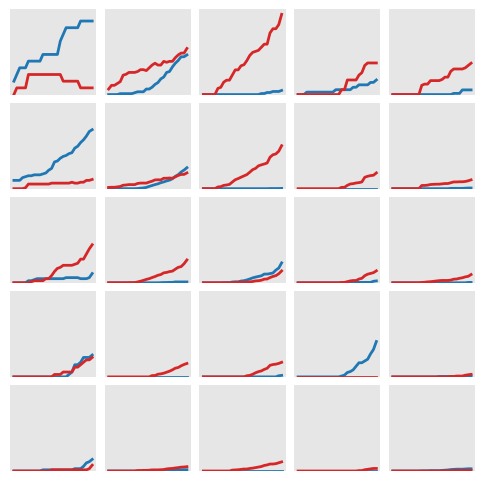

In [11]:


fig = plt.figure(figsize = (6,6))
gs = gridspec.GridSpec(nc,nc)
gs.update(wspace=0.1, hspace=0.1) # set the spacing between axes. 

fontProperties = {'family':'sans-serif','sans-serif':['Helvetica'],
    'weight' : 'normal', 'size' : 12}

for ic in fullcnames:
    for jc in fullcnames:
        
        ax = plt.subplot(gs[ic * nc + jc])
  
        ax.plot(np.arange(1990, 2018), pblock_matrix[:,ic,jc], lw=2)
        ax.plot(np.arange(1990, 2018), nblock_matrix[:,ic,jc], lw=2, color=sns.color_palette()[3])
        
        ax.set_ylim([0, 0.8])
        ax.set_yticks([0,0.75])
        
        ax.tick_params(axis='y', which='major', labelsize=10)
        for tick in ax.get_yticklabels():
            tick.set_fontname("Helvetica") #"Comic Sans MS")
        
        for tick in ax.get_xticklabels():
            tick.set_fontname("Helvetica")
            tick.set_rotation(45)

        #if ~(ic == 0 and jc ==2 or ic==2 and jc ==0):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        ax.set_facecolor('0.9')
        
        if jc > -1:
            ax.set_yticks([])
        
        if ic <6:
            ax.set_xticks([])


plt.show()

# Multinomial Link Prediction

In [36]:
panel_data = pd.read_csv(os.path.join(path2countrydata, 'link_prediction_panel_data_1990_2017.csv.gz'))


net_panel = panel_data.merge(net_auc.rename(columns={'CitingCountry':'oCountry', 'CitedCountry':'tCountry','CitedYear':'year'}), 
                           how='left', on=['oCountry','tCountry','year'])

net_panel['edge_preference'] = 1 + (net_panel['Zscore'] < 0).astype(int)
net_panel.loc[net_panel['Significant'].isnull(), 'edge_preference'] = 0

net_panel['edge_preference'].unique()

dummy_years=['year_'+str(i) for i in range(syear + 1, eyear + 1)]

all_dummies=['comlang_off','SameContinent']+dummy_years

net_panel_with_dummies = pd.get_dummies(net_panel, columns=['year'], drop_first=True)
net_panel_with_dummies[dummy_years] = net_panel_with_dummies[dummy_years].astype(int)



v1=['oGDP_PCAP','tGDP_PCAP', 'oPop','tPop']
v2=['PhysicalDistance','SameContinent']
v3=['comlang_off','TopicSimilarity']
v4=['cumulative_laws']
v5=['CollabStrength']
v6=['oTopFrac','tTopFrac']


all_model_features = v1 + v2 + v3 + v4 + v5 + v6

exog_var_sets = [v1+dummy_years,v2,v3,v4,v5,v6]
dep_var = "edge_preference"

Nmodels = len(exog_var_sets)

fit_models = []
for icol in range(Nmodels):
    exog_vars = list(chain.from_iterable(exog_var_sets[:(icol+1)]))
    X = net_panel_with_dummies[exog_vars + [dep_var]].dropna().reset_index(drop=True)

    Y = X[dep_var]
    X = sm.add_constant(X[exog_vars])

    for c in exog_vars:
        if X[c].nunique() > 2:
            X[c] = (X[c] - X[c].mean())/X[c].std()

    model = sm.MNLogit(Y, X).fit()
    fit_models.append(model)
    

Optimization terminated successfully.
         Current function value: 0.035284
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.036045
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.038455
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.038375
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.036143
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.034350
         Iterations 13


In [16]:
%load_ext autoreload
%autoreload 2

In [26]:

from vizutils import pvalue2stars, table_row, make_multinomial_latex_table, logistic_coefficient_plot

namedict = {'const':'Intercept', 'oTopFrac':'Origin top journal fraction', 'tTopFrac':'Target top journal fraction', 
'oGDP_PCAP':'Log origin GDP per capita', 'oPop':'Log origin population','tPop':'Log target population',
           'tGDP_PCAP':'Log target GDP per capita', 'PhysicalDistance': 'Physical distance', 'TopicSimilarity':'Field similarity', 
            'comlang_off':'Same official language', 'CollabStrength':'Log collaboration strength','SameContinent':'Same continent',
           'cumulative_laws':'Bilateral research agreements'}
years={i: i[-4:] for i in dummy_years}
merged_namedict = years.copy()  # Create a copy of dict1 to avoid modifying the original
merged_namedict.update(namedict)

make_multinomial_latex_table(fit_models, exog_var_sets, dep_var, merged_namedict, caption_text="")


{\tiny
    \begin{longtable}{p{0.2\linewidth}p{0.12\linewidth}p{0.12\linewidth}p{0.12\linewidth}p{0.12\linewidth}p{0.12\linewidth}}\caption{\textbf{Fixed-effect multinomial logit regression.} Model coefficients labelled by $p$-value. Standard errors in parentheses.} 
      \label{table:multinomialfull} \\
      \hline \hline \\
    \multicolumn{6}{c}{\textbf{Dependent variable: Citation preference}} \\ \hline 
     & \multicolumn{5}{c}{Model}  \\\cline{2-6}& (1)& (2)& (3)& (4)& (5)\\[0.8ex]
    \hline
    \endfirsthead\multicolumn{2}{c}%
      {{\tablename\ \thetable{} -- continued from previous page}} \\
      \hline \\& (1)& (2)& (3)& (4)& (5)\\
      \hline
      \endhead \hline&&&&\multicolumn{2}{r}{{Continued on next page}} \\ \endfoot
    \hline
    \caption*{} \\
    \endlastfoot$\mathbf{Citation~Preference: Positive}$ & & & & & \\ [1.8ex]Intercept & $-15.92^{***}$ & $-16.64^{***}$ & $-17.22^{***}$ & $-17.4^{***}$ & $-13.55^{***}$\\ 
 & $(-16.61,-15.23)$ & $(-17.34,-15.93)$ & $(

## multinomial VIF

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant


# Add a constant (Intercept) for VIF calculation
X = net_panel_with_dummies[v1+v2+v3+v4+v5+v6+dummy_years].dropna().reset_index(drop=True)# Adds an intercept term
X = sm.add_constant(X)

# Compute VIF for each feature
vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

namedict = {'const':'Intercept', 'oTopFrac':'Origin top journal fraction', 'tTopFrac':'Target top journal fraction', 'oGDP_PCAP':'Log origin GDP per capita', 'oPop':'Log origin population','tPop':'Log target population',
           'tGDP_PCAP':'Log target GDP per capita', 'PhysicalDistance': 'Physical distance', 'TopicSimilarity':'Field similarity', 
            'tradeflow_baci':'Log trade volume', 'comlang_off':'Same official language', 'CollabStrength':'Log collaboration strength','DemocDis': 'Democracy distance','oDemoc':'Origin democracy','tDemoc':'Target democracy','SameContinent':'Same continent',
           'cumulative_laws':'Bilateral research agreements'}

vif_df.replace(namedict,inplace=True)
vif_plot=vif_df[vif_df['Variable']!='Intercept']



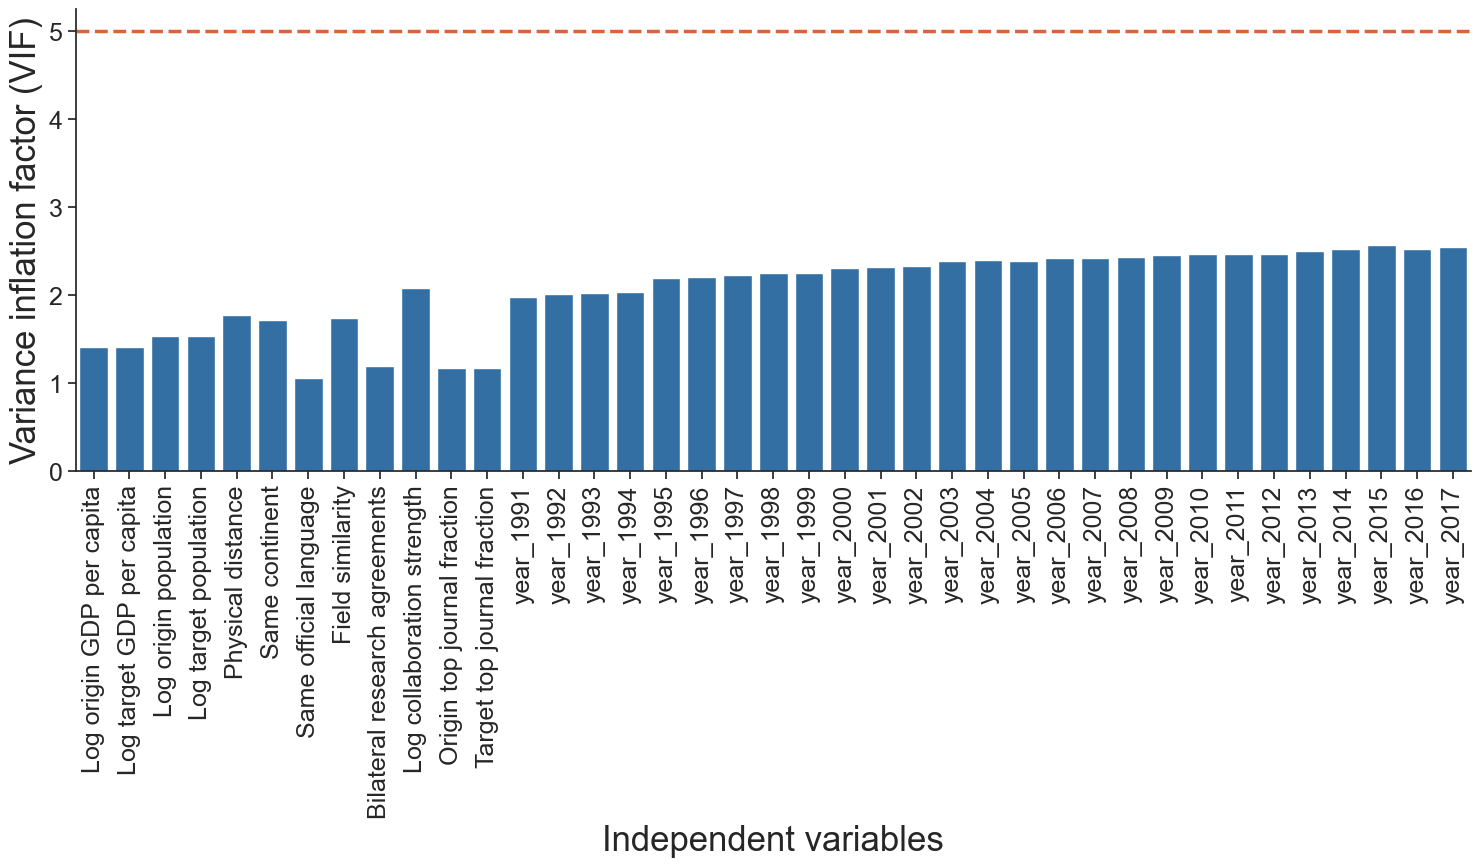

In [21]:
colours=['#8D95A0','#2171b5','#DA6437']

custom_params = {"axes.spines.bottom": True, "axes.spines.right": False, "axes.spines.top": False,
                     "axes.spines.left": True,"ytick.left":True, "xtick.bottom":True}
sns.set_theme(style='ticks', rc=custom_params)


plt.figure(figsize=(18, 6))

ax = sns.barplot(x="Variable", y="VIF", data=vif_plot, 
                     color=colours[1])
    
plt.xlabel("Independent variables", fontsize=25)
plt.ylabel("Variance inflation factor (VIF)", fontsize=25)

plt.xticks(rotation=90, ha='center')

ax.axhline(y=5, color=colours[2],  linestyle='--', lw=2.5)



ax.tick_params(axis='both', which='major', labelsize=18, direction='out',)

plt.show()

In [43]:
def summary_table(model,ycat,ycat_name):
    
    dfpo=model.params.reset_index().rename(columns={'index':'item'})
    dfc1=dfpo[['item',ycat-1]].rename(columns={ycat-1:'risk'})
    
    dfpv=model.pvalues.reset_index().rename(columns={'index':'item'})
    dfpv=dfpv[['item',ycat-1]].rename(columns={ycat-1:'pvalues'})

    df1=dfc1.merge(dfpv,how='left',on='item')
    
    dfcon1=model.conf_int().loc[str(ycat)].reset_index().rename(columns={'index':'item','lower':0,'upper':1})
    df2=df1.merge(dfcon1,how='left',on='item')

    df2['strf']=ycat_name

    return df2

dfc1=summary_table(fit_models[-1],1,'Positive recognition')
dfc2=summary_table(fit_models[-1],2,'Negative recognition')

dfs=pd.concat([dfc1,dfc2])

namedict = {'const':'Intercept', 
            'oTopCumuFrac':'Source top journal fraction', 'tTopCumuFrac':'Target top journal fraction',
            'oPop':'Source population','tPop':'Target population',
             'oGDP_PCAP':'Source GDP per capita', 'tGDP_PCAP':'Target GDP per capita',
            'oTopFrac':'Source top journal fraction', 'tTopFrac':'Target top journal fraction',
            'PhysicalDistance': 'Physical distance', 'tradeflow_baci':'Trade volume', 
            'FieldDistance':'Topic distance', 'SameContinent':'Same continent',
            'CollabStrength':'Collaboration strength',
            'CosineNormStrength':'Normed collaboration strength',
            'comlang_off':'Same official language', 
            'DemocDis': 'Democracy distance','oDemoc':'Source democracy', 'tDemoc':'Target democracy',
           'oGNI_PCAP':'Source GNI per capita', 'tGNI_PCAP':'Target GNI per capita',
           'GNI_PCAP':'GNI per capita', 'GNI':'GNI', 'GDP_PCAP':'GDP per capita',
           'Pop':'Population', 'NumPub':'Number of publications','Agreements':'Bilateral research agreement',
           'RND_per':'Percent of GDP for R&D', "FractionNationalAuthors":"Fraction national authors"}

dfs.replace(namedict,inplace=True)

dfs['category']=dfs['item']

#drop the year fixed effect rows
dfs = dfs[~dfs['item'].str.contains('year')].reset_index(drop=True)

df1 = dfs[dfs["strf"] == "Positive recognition"].reset_index(drop=True)
df2 = dfs[dfs["strf"] == "Negative recognition"].reset_index(drop=True)

df1['xerror']=df1[1]-df1['risk']
df2['xerror']=df2[1]-df2['risk']

df1=df1[df1['item']!='Intercept']
df2=df2[df2['item']!='Intercept']

#dfs

In [45]:
def wald_mlogit_diff(model, param1, param2=None):
    covar = model.cov_params()
    flipvalue = {'1':'2', '2':'1'}
    if param2 is None:
        param2 = ":".join([flipvalue.get(p, p) for p in param1.split(':')])

    pidx1 = tuple(param1.split(':'))[::-1]
    pidx2 = tuple(param2.split(':'))[::-1]

    diffse = np.sqrt( covar[pidx1][pidx1] + covar[pidx2][pidx2] - 2*covar[pidx1][pidx2] )

    coeffdiff = model.params[int(pidx1[0])-1][pidx1[1]] - model.params[int(pidx2[0])-1][pidx2[1]]
    zscore = coeffdiff/diffse
    pvalue = spstats.norm.sf(np.abs(zscore))*2
    
    return zscore, pvalue

for it in dfc1['item'].values:
    if it != 'const':
        param1 = it+':1'
        print(merged_namedict[it], wald_mlogit_diff(fit_models[-1], param1))


Log origin GDP per capita (np.float64(-26.337605166338875), np.float64(7.117600815319841e-153))
Log target GDP per capita (np.float64(-36.917699700648534), np.float64(2.403358859209785e-298))
Log origin population (np.float64(-31.194558757522568), np.float64(1.2627813638130013e-213))
Log target population (np.float64(-30.49788039012076), np.float64(2.7800920330457114e-204))
1991 (np.float64(-0.10764840036928087), np.float64(0.9142746020933072))
1992 (np.float64(-0.5463375477614676), np.float64(0.5848339306842147))
1993 (np.float64(0.4775186856709743), np.float64(0.6329928182655072))
1994 (np.float64(-0.0976490620266879), np.float64(0.9222109647705848))
1995 (np.float64(-0.3427132610116775), np.float64(0.7318141854173555))
1996 (np.float64(-0.7908980377295035), np.float64(0.429003493570708))
1997 (np.float64(-0.9183988656254787), np.float64(0.3584100843849892))
1998 (np.float64(-0.9384535952957129), np.float64(0.3480113539907287))
1999 (np.float64(-1.128701241621403), np.float64(0.25902

/Users/hgt6rn/Documents/GitHub/pyscisci/examples/GlobalCitationNetwork/vizutils.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fontsize=10,


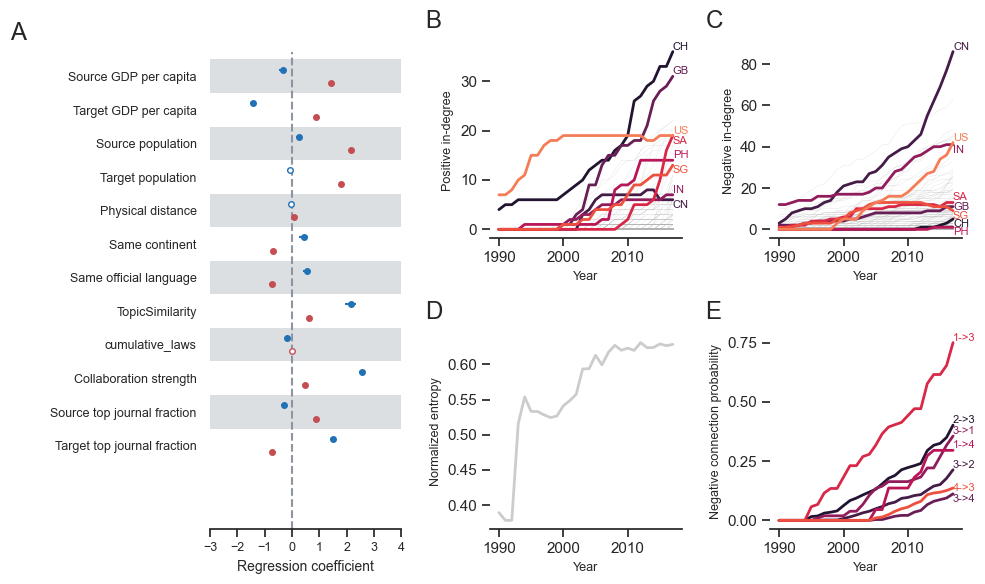

In [46]:
countries2highlight = sorted(['US', 'CH', 'GB', 'PH', 'SA', 'SG', 'CN', 'IN'])

lblsize = 9

colours=['#8D95A0','#2171b5','#DA6437']
colours=['#8D95A0','#2171b5',sns.color_palette()[3]]


layout = [
    ["A", "B", "C"],
    ["A", "D", "E"]
]

fig, axd = plt.subplot_mosaic(layout, figsize=(10,6))

logistic_coefficient_plot(df1, df2, colours, all_model_features, ax=axd["A"])

label = "A"
trans = mtransforms.ScaledTranslation(-2, 7/72, fig.dpi_scale_trans)
axd[label].text(0.0, 1.0, label, transform=axd[label].transAxes + trans,
                   fontsize='x-large', va='center')

comm2color = {0:"#257BA0", 1:"#6AB8AB", 2:"#D65451", 3:"#FFE000", 4:"#FF9400"}

for c in countryprod['Country'].unique():
    countrysub = countryprod[countryprod['Country'] == c].sort_values('Year')
    
    if c in countries2highlight:
        color = sns.color_palette("rocket", n_colors=len(countries2highlight) + 2)[countries2highlight.index(c)]
        axd["B"].plot(countrysub['Year'].values, countrysub['PositiveInDegree'].values, color=color, lw=2, zorder=10)
        axd["C"].plot(countrysub['Year'].values, countrysub['NegativeInDegree'].values, color=color, lw=2, zorder=10)
        
        if c in ['CN', 'SA', 'SG']:
            axd["B"].text(s=c, x=countrysub['Year'].values[-1], y=countrysub['PositiveInDegree'].values[-1],
                    ha='left', va='top', color=color, fontsize=8)
        else:
            axd["B"].text(s=c, x=countrysub['Year'].values[-1], y=countrysub['PositiveInDegree'].values[-1],
                    ha='left', va='bottom', color=color, fontsize=8)
        
        if c in ['IN', 'PH', 'CH', 'SG']:
            axd["C"].text(s=c, x=countrysub['Year'].values[-1], y=countrysub['NegativeInDegree'].values[-1],
                    ha='left', va='top', color=color, fontsize=8)
        elif c in ['GB']:
            axd["C"].text(s=c, x=countrysub['Year'].values[-1], y=countrysub['NegativeInDegree'].values[-1],
                    ha='left', va='center', color=color, fontsize=8)
        else:
            axd["C"].text(s=c, x=countrysub['Year'].values[-1], y=countrysub['NegativeInDegree'].values[-1],
                    ha='left', va='bottom', color=color, fontsize=8)
    else:    
        axd["B"].plot(countrysub['Year'].values, countrysub['PositiveInDegree'].values, color='0.7', lw=0.1, zorder=1)
        axd["C"].plot(countrysub['Year'].values, countrysub['NegativeInDegree'].values, color='0.7', lw=0.1, zorder=1)

axd["B"].set_ylabel('Positive in-degree', fontsize=lblsize)
axd["C"].set_ylabel('Negative in-degree', fontsize=lblsize)
axd["D"].set_ylabel('Normalized entropy', fontsize=lblsize)
axd["E"].set_ylabel('Negative connection probability', fontsize=lblsize)

#axd["E"].axis('off')

axd['D'].plot(np.arange(1990, 2018), yent, color='0.8', lw=2)

for i,(ic,jc) in enumerate([(1,2), (2,1), (2,3),  (2,0),(0,3), (0,2), (3,2)]):
    color=sns.color_palette("rocket", n_colors=len(countries2highlight) + 2)[i]
    axd["E"].plot(np.arange(1990, 2018), nblock_matrix[:,ic,jc], lw=2, color=color)
    
    if (ic,jc) in [(3,0),  (2,3)]:
        va = 'top'
    elif (ic,jc) in [(3,2), (3,0)]:
        va = 'center'
    else:
        va = 'bottom'
    axd["E"].text(s=str(ic+1)+"->"+str(jc+1), x=2017, y=nblock_matrix[-1,ic,jc], ha='left', va=va, 
                  color=color, fontsize=8)

#axd["E"].set_yticks([0, 0.25, 0.5,0.75])
axd["E"].set_yticks([0, 0.25, 0.5,0.75])


for label in ['B', "C", "D", "E"]:
    axd[label].set_xlabel('Year', fontsize=lblsize)
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(-0.65, 7/72, fig.dpi_scale_trans)
    axd[label].text(0.0, 1.0, label, transform=axd[label].transAxes + trans,
                   fontsize='x-large', va='bottom')#, xx-small, x-small, small, medium, large, x-large, xx-large, larger, smaller
plt.tight_layout()

#plt.savefig('Figures/Fig2_networkfeatures.pdf')

plt.show()

# Weighted Logistic Regression Model for Idea Diffusion

In [47]:
panel_data = pd.read_csv('data/diffusion_panel_data_1990_2017.csv.gz')



network_features = [ 'Pedge', 'Nedge'] 
#network_features = [ 'Pedge', 'Nedge', 'SameComm'] 
#network_features = [ 'Pedge', 'Nedge',  'pr_o', 'pr_d'] 
network_features = [ 'Pedge', 'Nedge', 'SameComm', 'pr_o', 'pr_d'] 

Model_features = [
#'Pop_o','Pop_d', 
'GDP_PCAP_o','GDP_PCAP_d',
'NumPub_o','NumPub_d', 
'NormNcites',  
'FieldDistance', 
'dist', 
'comlang_off'
] + network_features


X = panel_data[Model_features + [ 'Norigin', 'Fideas']].dropna().copy()
Y = X['Fideas']
freq_weights = X['Norigin'].values
X = sm.add_constant(X[Model_features])

for c in Model_features:
    if X[c].nunique() > 2:
        X[c] = (X[c] - X[c].mean())/X[c].std()

vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_df['Variable']=vif_df['Variable'].replace(namedict)

#model=sm.GLM(Y, X, family=sm.families.Binomial(sm.families.links.logit())).fit()
model=sm.GLM(Y, X, family=sm.families.Binomial(sm.families.links.logit()), freq_weights=freq_weights).fit()

predictions = model.predict(X) 
print(model.pseudo_rsquared(kind='mcf'))
params = model.params
conf = model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf))

model.summary()

0.424811934179966
                     5%       95%  Odds Ratio
const          0.254320  0.262404    0.258330
GDP_PCAP_o     1.319744  1.343300    1.331470
GDP_PCAP_d     1.083653  1.093667    1.088649
NumPub_o       0.730610  0.746141    0.738335
NumPub_d       4.741752  4.796227    4.768912
NormNcites     1.054395  1.058477    1.056434
FieldDistance  0.714497  0.721512    0.717996
dist           1.010699  1.019164    1.014923
comlang_off    0.989790  1.010325    1.000005
Pedge          1.126826  1.155277    1.140963
Nedge          0.952675  0.969649    0.961125
SameComm       1.071280  1.095541    1.083343
pr_o           1.007300  1.015541    1.011412
pr_d           1.039934  1.048757    1.044336


/opt/homebrew/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Fideas   No. Observations:                12032
Model:                            GLM   Df Residuals:                  2814066
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -7.9875e+05
Date:                Tue, 10 Feb 2026   Deviance:                       39890.
Time:                        15:04:42   Pearson chi2:                 4.34e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.3535      0.008   -169.549      0.000      -1.369      -1.338
GDP_PCAP_o        0.2863      0.005     63.434      0.000       0.277       0.295
GDP_PCAP_d        0.0849      0.002     36.196      0.000       0.080       0.090
NumPub_o         -0.3034      0.005    -56.533      0.000      -0.314      -0.293
NumPub_d          1.5621      0.003    536.070      0.000       1.556       1.568
NormNcites        0.0549      0.001     55.694      0.000       0.053       0.057
FieldDistance    -0.3313      0.002   -132.926      0.000      -0.336      -0.326
dist              0.0148      0.002      6.962      0.000       0.011       0.019
comlang_off    5.065e-06      0.005      0.001      0.999      -0.010       0.010
Pedge             0.1319      0.006     20.730      0.000       0.119       0.144
Nedge            -0.0397      0.005     -8.801      0.000      -0.048      -0.031
SameComm          0.0801      0.006     14.012      0.000       0.069       0.091
pr_o              0.0113      0.002      5.459      0.000       0.007       0.015
pr_d              0.0434      0.002     20.130      0.000       0.039       0.048
=================================================================================
"""